In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [3]:
using DifferentialEquations, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, OneHotArrays, JLD2
using Plots, QuadGK
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives
using Statistics: mean

In [4]:
using ChainRulesCore: ignore_derivatives

In [5]:
using Base: @kwdef

# Load the dataset

In [6]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [7]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [8]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [9]:
data_dir = "pixel_data/"

"pixel_data/"

In [10]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [11]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [12]:
size(q)

(20, 13, 21, 99991)

In [13]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [14]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [15]:
q |> size

(20, 13, 21, 99991)

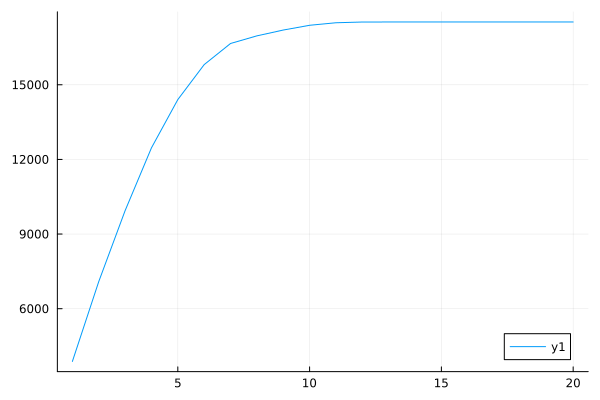

In [16]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

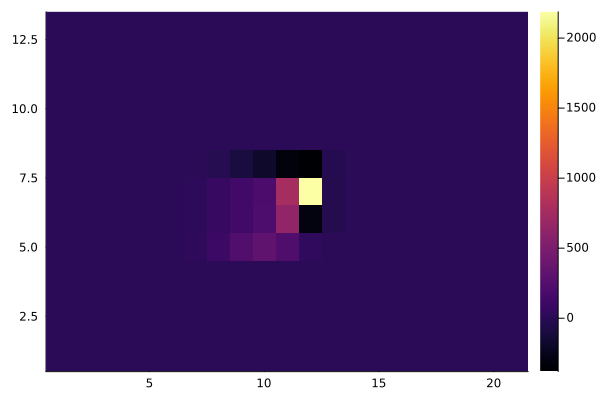

In [17]:
heatmap(q[1,:,:,128])

In [18]:
x = q[:,:,:,1:128]
xl = ylocal[1:128]
y = pt[1:128];

In [19]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [20]:
x |> size

(20, 13, 21, 128)

In [21]:
n_px = size(x, 2) 
n_in = n_px + 1

14

In [22]:
spk_args = SpikingArgs(threshold=1e-5, leakage=-0.2, solver=Tsit5())
tspan = (0.0, 25.0)

(0.0, 25.0)

# Drive currents into Phases

In [23]:
x_tms = range(start=0.0, stop=1.0, length=size(x,1)) |> collect;

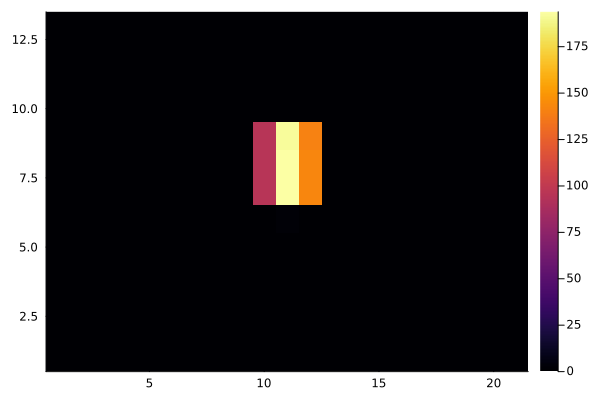

In [24]:
heatmap(interpolate_2D_derivative(0.5, x_tms, x)[:,:,1])

In [25]:
xi = charge_to_current(x, spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(var"#28#30"{Float64, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}, var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}}(0.01, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.

In [26]:
xi.current.shape

(13, 128)

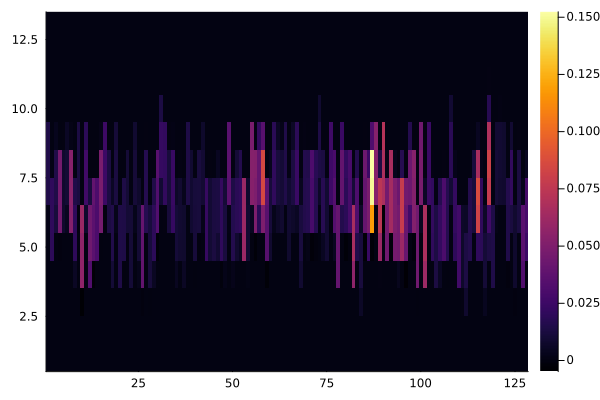

In [27]:
heatmap(xi.current.current_fn(0.4))

In [28]:
xli = ylocal_to_current(xl, spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, (0.0, 25.0))

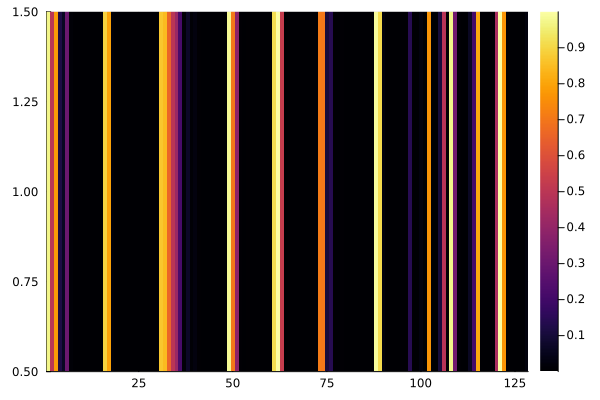

In [29]:
heatmap(xli.current.current_fn(0.7))

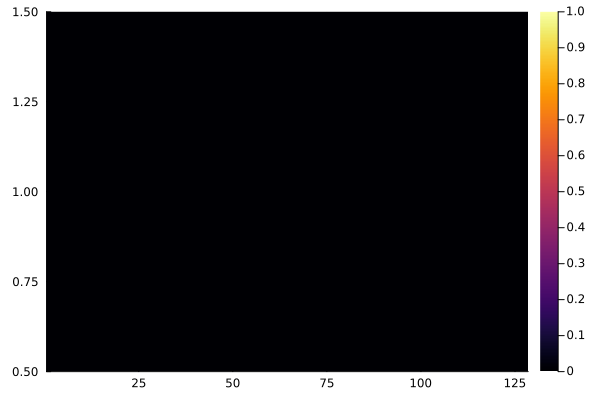

In [30]:
heatmap(xli.current.current_fn(1.7))

In [31]:
xli

CurrentCall(LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, (0.0, 25.0))

In [32]:
xli.t_span

(0.0, 25.0)

In [33]:
xi.current.shape

(13, 128)

In [34]:
xxli = cat_currents(xi, xli, dim=1)

CurrentCall(LocalCurrent(var"#34#36"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), LocalCurrent(var"#28#30"{Float64, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}, var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}}(0.01, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 

In [35]:
xxli.current.shape

(14, 128)

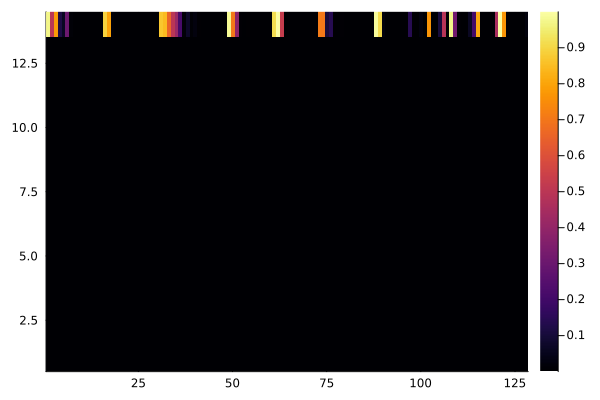

In [36]:
heatmap(xxli.current.current_fn(0.7))

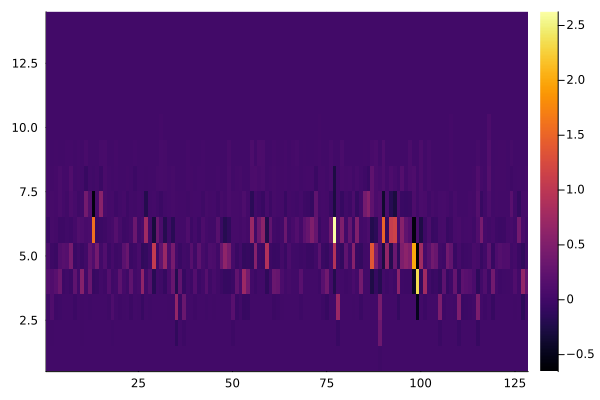

In [37]:
heatmap(xxli.current.current_fn(0.3))

In [38]:
stats_sample = [vec(xxli.current.current_fn(t)) for t in 0.0:0.05:1.25] |> stack;

In [39]:
extrema(stats_sample)

(-0.9585047619047619, 4.74392)

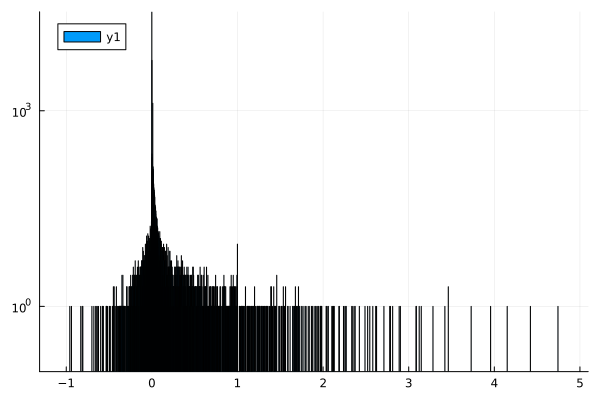

In [40]:
histogram(vec(stats_sample), yscale=:log10)

In [41]:
x1 = process_sample((x, xl), spk_args=spk_args, tspan=tspan, clock_amp=0.01)

CurrentCall(LocalCurrent(var"#34#36"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), LocalCurrent(var"#28#30"{Float64, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}, var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}}(0.01, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 

In [42]:
ode_front = Chain(PhasorResonant(n_in, spk_args),)

PhasorResonant(14, PhasorNetworks.var"#170#172"{Int64}(14), true, true)

## Setup the Resonating Layer

In [43]:
conversion_loader = DataLoader((q, ylocal), partial = false, batchsize=args.batchsize)

781-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64},)

In [44]:
function data_to_phase(q, yl; spk_args::SpikingArgs, tspan::Tuple, clock_amp::Real = 0.01)
    x = process_sample((q, yl), spk_args=spk_args, tspan=tspan, clock_amp=clock_amp)
    ode_front = Chain(PhasorResonant(n_in, spk_args),)

    rng = Xoshiro(42)
    ps_ode, st_ode = Lux.setup(rng, ode_front)
    sol = ode_front(x, ps_ode, st_ode)[1]
    mp = mean_phase(sol, 1, spk_args=spk_args, offset=0.0, threshold=false)
    train = solution_to_train(sol, tspan, spk_args=spk_args, offset=0.0)

    return mp, train
end

data_to_phase (generic function with 1 method)

In [45]:
@time res = map(x -> data_to_phase(x[1], x[2], spk_args=spk_args, tspan=tspan, clock_amp=0.01), conversion_loader)

2964.293872 seconds (1.37 G allocations: 11.024 TiB, 61.73% gc time, 0.13% compilation time: <1% of which was recompilation)


781-element Vector{Tuple{Matrix{Float64}, SpikeTrain}}:
 ([8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 8.027930012639297e-5 0.004183077829371918 … -0.0011375131306584083 8.027930012639297e-5; … ; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.3932949406369889 0.4333621008406524 … 0.5021470917411814 0.478040080076592], Spike Train: (14, 128) with 37591 spikes.)
 ([8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.09794787993500552 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; … ; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.4901712717909984 0.5259724582184019 … 0.5275250419705408 0.5437253478043104], Spike Train: (14, 128) with 37713 spikes.)
 ([8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.02793

In [46]:
x_mp = cat([r[1] for r in res]..., dims=2)

14×99968 Matrix{Float64}:
  8.02793e-5   8.02793e-5   8.02793e-5  …   8.02793e-5   0.44134
  8.02793e-5   0.00418308   8.02793e-5      8.02793e-5  -0.532472
  0.0432962   -0.560948     0.90813         8.02793e-5  -0.619765
 -0.520995    -0.618984    -0.536483        0.00239922  -0.820587
 -0.622305    -0.777265    -0.681835       -0.810017    -0.836396
 -0.765468    -0.938604    -0.800591    …  -0.647021    -0.704489
 -0.860354    -0.113524    -0.914184        0.996653    -0.515151
 -0.702822    -0.767156    -0.153026        0.0876113   -0.0286546
 -0.513788     8.02793e-5  -0.715589       -0.690388     8.02793e-5
 -0.858642     8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5  …   8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  0.393295     0.433362     0.380176        0.590602     0.406229

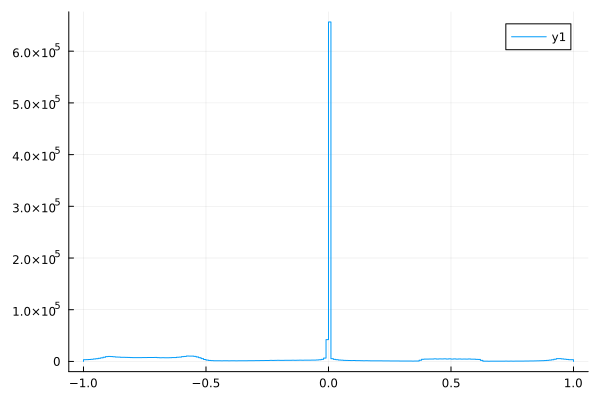

In [47]:
histogram(vec(x_mp))

In [48]:
#x_mp, _ = data_to_phase(q, ylocal, spk_args=spk_args, tspan=tspan, clock_amp=0.01)

In [49]:
train_loader = DataLoader((x_mp, pt[1:size(x_mp, 2)]), partial = false, batchsize=args.batchsize)

781-element DataLoader(::Tuple{Matrix{Float64}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (14×128 Matrix{Float64}, 128-element Vector{Float64},)

# Setup the Classifying Model

In [50]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [51]:
ode_model = Chain(
                PhasorDenseF32(n_in => 128),
                PhasorDenseF32(128 => 3)
                )

Chain(
    layer_1 = PhasorDenseF32((14, 128)),  # 2_048 parameters
    layer_2 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_438 parameters,
          #        plus 0 states.

In [52]:
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [53]:
x1 = first(train_loader)

([8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 8.027930012639297e-5 0.004183077829371918 … -0.0011375131306584083 8.027930012639297e-5; … ; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.3932949406369889 0.4333621008406524 … 0.5021470917411814 0.478040080076592], [0.656019, 0.637776, -1.54754, 0.46886, 0.555289, -0.438797, 0.740845, 0.544609, -0.727205, -0.941404  …  0.817292, 0.540987, 1.22233, -0.523964, -0.889413, 2.83394, 0.587626, -0.874592, -0.698757, -0.555948])

In [54]:
y_naive, _ = ode_model(x1[1], ps, st);

In [55]:
y_naive

3×128 Matrix{Float64}:
  0.948022     0.585697    0.838117    …   0.65951     0.69358    -0.900527
 -0.930993     0.962835   -0.984828        0.973076    0.92679    -0.974082
 -0.00929619  -0.0421718   0.00240765     -0.0131629  -0.0341874  -0.0255742

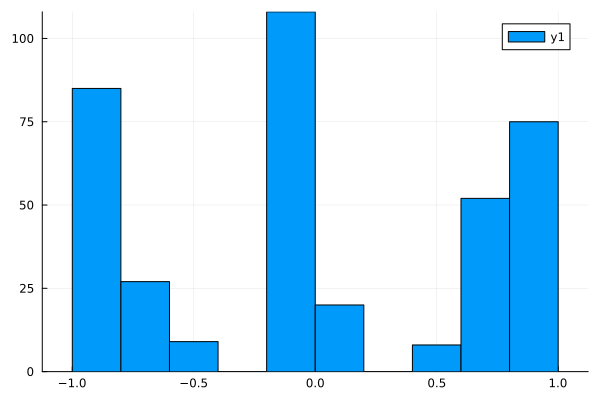

In [56]:
histogram(y_naive |> vec, bins=10)

In [57]:
psf = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [58]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [59]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [60]:
function loss(x, y, model, ps, st, threshold)
    y_pred, st = model(x, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [61]:
loss(x1[1], x1[2], ode_model, psf, st, 0.2)

(1.2765906759359056, (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [62]:
v, gs = withgradient(p -> loss(x1[1], x1[2], ode_model, p, st, 0.2), psf)

(val = (1.2765906759359056, (layer_1 = NamedTuple(), layer_2 = NamedTuple())), grad = ((layer_1 = (weight = Float32[-0.001904778 -0.0017818615 … -0.0019027408 -0.0045394255; -0.002397524 -0.003377411 … -0.0023858026 0.042496383; … ; 0.008462163 0.008826169 … 0.008612495 0.016422512; -0.0136015015 -0.012751658 … -0.013588302 -0.050071035], bias_real = Float32[-0.0019014076, -0.0023966257, 0.005059178, -0.080100715, 0.008176556, 0.009503002, -0.004480927, -0.012488255, -0.0043169605, 0.124849685  …  0.007977639, -0.07750834, -0.00063888135, 0.00042757095, 0.009953481, -0.001658749, -0.0012712743, -0.0016245934, 0.008608143, -0.01357477], bias_imag = Float32[-0.005286009, 0.04291456, 0.018324006, -0.0647658, -0.032169297, -0.014557825, -0.014676604, -0.055254724, 0.0031250315, -0.0453799  …  0.023433076, 0.17856187, -0.0085662715, -0.006318715, -0.03896086, -0.0082501, -0.03301794, 0.030650625, 0.017257297, -0.053657252]), layer_2 = (weight = Float32[-0.85001725 -0.8246893 … -0.79366726 -

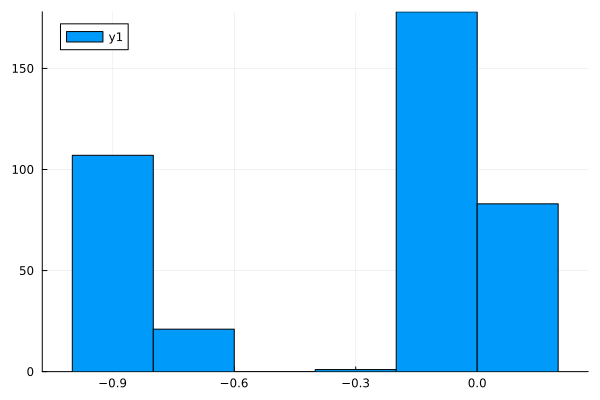

In [63]:
histogram(vec(gs[1].layer_2))

In [64]:
function train(model, ps, st, train_loader; threshold::Real = 0.2, id::Int=1, verbose::Bool = true, kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        print("Epoch ", epoch)
        epoch_losses = []
        for (x, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
            if verbose
                println(reduce(*, ("Epoch ", string(epoch), ", loss ", string(loss_val))))
            end
        end
        append!(losses, epoch_losses)
        println(" mean loss ", string(mean(epoch_losses)))
        #filename = joinpath("parameters", "id_") * string(id) * "_epoch_" * string(epoch) * ".jld2"
        #jldsave(filename; params=ps, state=st)
    end

    return losses, ps, st
end

train (generic function with 1 method)

In [65]:
loss_history, pst, stt = train(ode_model, psf, st, train_loader, threshold = 0.2, epochs = 10, verbose=false);

Epoch 1

[ Info: Constructing model and starting training


 mean loss 0.2263489585393369
Epoch 2 mean loss 0.19910502051141962
Epoch 3 mean loss 0.1875695660785689
Epoch 4 mean loss 0.17272504616750783
Epoch 5 mean loss 0.165029543603846
Epoch 6 mean loss 0.16184095725213113
Epoch 7 mean loss 0.16002939966720395
Epoch 8 mean loss 0.15887271939922035
Epoch 9 mean loss 0.15763024892762847
Epoch 10 mean loss 0.15677898623785796


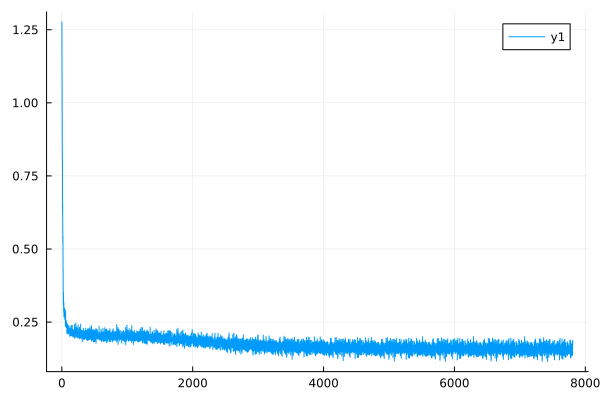

In [66]:
plot(loss_history)

In [67]:
#loss_history2, pst2, stt2 = train(ode_model, pst, st, train_loader, threshold = 0.2, epochs = 10)

In [68]:
#plot(append!(loss_history, loss_history2))

In [69]:
loss_history[end]

0.18335609978758208

In [70]:
#load params

In [71]:
#res = load("trained_nns/ode_id_43_epoch_100.jld2")

In [72]:
# pst = res["params"]
# stt = res["state"]

In [73]:
pst2 = pst

ComponentVector{Float32}(layer_1 = (weight = Float32[0.015459658 0.123286635 … 0.027673563 -0.11433808; -0.092772745 0.019092083 … 0.09314226 -0.17031808; … ; 0.17843105 -0.21683052 … -0.11136853 -0.17186236; 0.15072857 -0.054255884 … 0.15830626 -0.16250947], bias_real = Float32[1.0476778, 0.95673466, 1.0111377, 0.9440639, 0.9695657, 0.9200769, 0.98337126, 1.0092449, 0.95524806, 1.0744231  …  1.0002291, 1.0204548, 0.9694604, 0.94951487, 0.9683739, 1.0324715, 1.0875232, 0.7774135, 0.97775686, 1.1328864], bias_imag = Float32[0.04037675, -0.035633724, 0.04457643, -0.056452036, 0.054354813, -0.08544872, -0.020946698, 0.0043916064, -0.0064099766, 0.03629325  …  -0.004002129, 0.0050840415, 0.024292104, 0.04581413, 0.03356945, 0.057601262, -0.0023145461, -0.03168984, -0.060503777, 0.05333195]), layer_2 = (weight = Float32[0.12487207 0.08694719 … -0.02177658 0.08504076; -0.018094981 -0.1454717 … 0.06516737 0.041660648; 0.01681055 -0.18580547 … -0.16026969 0.25485295], bias_real = Float32[1.027

In [74]:
loss(x1[1], x1[2], ode_model, pst2, stt, 0.2)

(0.15186507629056434, (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [75]:
yt, _ = ode_model(x1[1], pst2, stt)

([0.025641587349645376 0.02040329388620291 … 0.009288120482659366 0.015853450520046643; 0.3459682638851517 0.2006802889219911 … -0.024845356584154706 0.16154877976279558; 0.10651415550572148 0.27867596084814755 … 0.4226201535654128 0.32798525111222243], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

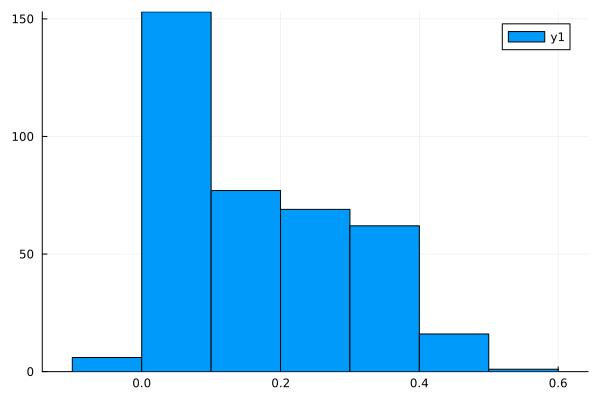

In [76]:
histogram(yt |> vec)

In [77]:
using JLD2

In [350]:
load_object("trained_resonant.jld2")

Dict{String, Any} with 2 entries:
  "params" => (layer_1 = (weight = Float32[0.0154597 0.123287 … 0.0276736 -0.11…
  "state"  => (layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [78]:
#trained = load_object("trained_resonant.jld2")

In [79]:
#pst2 = trained["params"]
#stt = trained["state"]

In [80]:
save_object("trained_resonant.jld2", Dict("params" => pst2, "state" => stt))

In [347]:
save_object("data/train_phase.jld2", Dict("phase" => x_mp, "momentum" => pt[1:size(x_mp,2)]))

# Calculate the Test Loss

In [82]:
conversion_loader2 = DataLoader((q_test, ylocal_test), partial = false, batchsize=args.batchsize)

390-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64},)

In [83]:
@time res2 = map(x -> data_to_phase(x[1], x[2], spk_args=spk_args, tspan=tspan, clock_amp=0.01), conversion_loader2)

1462.144003 seconds (678.82 M allocations: 5.504 TiB, 64.64% gc time, 0.00% compilation time)


390-element Vector{Tuple{Matrix{Float64}, SpikeTrain}}:
 ([8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 0.5905472311224801; … ; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.3988654168683693 0.49323492644574246 … 0.4688653423862285 0.44895933492519174], Spike Train: (14, 128) with 37722 spikes.)
 ([-0.0021490361585884384 8.027930012639297e-5 … 8.027930012639297e-5 0.18741235994649819; -0.9830478763888199 8.027930012639297e-5 … 8.027930012639297e-5 -0.5365204292194842; … ; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.4275770284564515 0.5660238602087987 … 0.5930600428168955 0.4011103160213345], Spike Train: (14, 128) with 37932 spikes.)
 ([0.708966648216544 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; -0.7354532203960392 0.9889372534725743 … 8.027930012639297e-5 -0.00804522158

In [299]:
test_mp = cat([r[1] for r in res2]..., dims=2)

14×49920 Matrix{Float64}:
  8.02793e-5   8.02793e-5   8.02793e-5  …   8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      0.0589719    8.02793e-5
 -0.00865065   8.02793e-5   8.02793e-5     -0.83953      0.681358
 -0.913239     0.945589     0.913288       -0.811302    -0.605143
 -0.576557    -0.562059    -0.583956       -0.657639    -0.676573
 -0.77469     -0.769594    -0.585233    …  -0.848923    -0.972279
 -0.908444     0.597186    -0.774989       -0.667203    -0.0154658
 -0.126592    -0.197584    -0.930905       -0.500955    -0.906083
 -0.712678    -0.00115278  -0.118475        8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5  -0.821431        8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5  …   8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  0.398865     0.493235     0.461341        0.440638     0.542911

In [302]:
test_train = [r[2] for r in res2]

390-element Vector{SpikeTrain}:
 Spike Train: (14, 128) with 37722 spikes.
 Spike Train: (14, 128) with 37932 spikes.
 Spike Train: (14, 128) with 37761 spikes.
 Spike Train: (14, 128) with 37795 spikes.
 Spike Train: (14, 128) with 37921 spikes.
 Spike Train: (14, 128) with 38093 spikes.
 Spike Train: (14, 128) with 37817 spikes.
 Spike Train: (14, 128) with 37854 spikes.
 Spike Train: (14, 128) with 37685 spikes.
 Spike Train: (14, 128) with 37936 spikes.
 Spike Train: (14, 128) with 37821 spikes.
 Spike Train: (14, 128) with 37833 spikes.
 Spike Train: (14, 128) with 37798 spikes.
 ⋮
 Spike Train: (14, 128) with 37783 spikes.
 Spike Train: (14, 128) with 38060 spikes.
 Spike Train: (14, 128) with 37834 spikes.
 Spike Train: (14, 128) with 37687 spikes.
 Spike Train: (14, 128) with 37906 spikes.
 Spike Train: (14, 128) with 37837 spikes.
 Spike Train: (14, 128) with 37760 spikes.
 Spike Train: (14, 128) with 37808 spikes.
 Spike Train: (14, 128) with 37881 spikes.
 Spike Train: (14, 

In [356]:
save_object("data/test_phase.jld2", Dict("phase" => test_mp, "momentum" => pt_test[1:size(test_mp,2)], "spikes" => test_train))

In [89]:
test_loader = DataLoader((test_mp, pt_test[1:size(test_mp,2)]), partial = false, batchsize=args.batchsize)

390-element DataLoader(::Tuple{Matrix{Float64}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (14×128 Matrix{Float64}, 128-element Vector{Float64},)

In [90]:
xts, yts = first(test_loader)

([8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 0.5905472311224801; … ; 8.027930012639297e-5 8.027930012639297e-5 … 8.027930012639297e-5 8.027930012639297e-5; 0.3988654168683693 0.49323492644574246 … 0.4688653423862285 0.44895933492519174], [-0.186883, -0.261643, 0.442997, -0.228423, 0.249504, -0.2267, 0.23921, 0.24106, -0.186514, -0.176539  …  0.866878, -0.379843, -0.321384, -1.15701, -0.660461, 0.814443, -1.28697, 0.619098, 0.392916, 0.621342])

In [91]:
function accuracy(x, y, model_call::Function, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred = model_call(x)
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 2 methods)

In [92]:
accuracy(xts, yts, x -> ode_model(x, pst2, stt)[1], 0.2)

93

In [93]:
xts

14×128 Matrix{Float64}:
  8.02793e-5   8.02793e-5   8.02793e-5  …   8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   0.590547
 -0.00865065   8.02793e-5   8.02793e-5      0.95285     -0.605266
 -0.913239     0.945589     0.913288       -0.551204    -0.619925
 -0.576557    -0.562059    -0.583956       -0.684405    -0.786118
 -0.77469     -0.769594    -0.585233    …  -0.848535    -0.899707
 -0.908444     0.597186    -0.774989       -0.885777    -0.53424
 -0.126592    -0.197584    -0.930905       -0.432813    -0.610513
 -0.712678    -0.00115278  -0.118475       -0.0530397    8.02793e-5
  8.02793e-5   8.02793e-5  -0.821431        8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5  …   8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  8.02793e-5   8.02793e-5   8.02793e-5      8.02793e-5   8.02793e-5
  0.398865     0.493235     0.461341        0.468865     0.448959

In [94]:
test_mp |> size

(14, 49920)

In [95]:
@time yth = ode_model(test_mp[:,1:10000], pst2, stt)[1]

  0.061886 seconds (5.03 k allocations: 103.890 MiB, 30.01% gc time, 8.34% compilation time)


3×10000 Matrix{Float64}:
  0.00970213   0.0114409  0.0234475  …  0.00470059  0.0474719  0.0153123
 -0.00790409  -0.0379778  0.229313      0.126622    0.0102051  0.18451
  0.424759     0.440017   0.145607      0.326015    0.377595   0.31776

In [96]:
@time yth = ode_model(test_mp, pst2, stt)[1]

  0.914104 seconds (35 allocations: 511.530 MiB, 76.44% gc time)


3×49920 Matrix{Float64}:
  0.00970213   0.0114409  0.0234475  …  0.0215463   0.0111571  0.0146086
 -0.00790409  -0.0379778  0.229313      0.350478    0.23568    0.252289
  0.424759     0.440017   0.145607      0.00927248  0.251508   0.19863

In [97]:
function accuracy_compare(y_pred, y, threshold::Real)
    y_labels = predict_quadrature(y_pred) .- 1
    y_truth = get_truth(y, threshold)
    right = sum(y_truth .== y_labels)
    return right
end

accuracy_compare (generic function with 1 method)

In [99]:
accuracy_compare(yth, pt_test[1:size(test_mp,2)], 0.2)

35842

In [100]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [101]:
using LinearAlgebra: diag

In [357]:
yth |> size

(3, 49920)

In [362]:
cat([x[2] for x in train_loader]..., dims=1)

99968-element Vector{Float64}:
  0.656019
  0.637776
 -1.54754
  0.46886
  0.555289
 -0.438797
  0.740845
  0.544609
 -0.727205
 -0.941404
  0.536136
  0.532368
 -1.34579
  ⋮
  0.235232
  0.388625
  0.358905
 -0.142791
 -0.269327
 -0.194908
  0.172541
  0.253184
  0.345484
  0.30403
  0.183736
  0.324287

In [360]:
pt_test[1:size(test_mp,2)] |> size

(49920,)

In [103]:
roc = tpr_fpr(yth, pt_test[1:size(test_mp,2)])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [104]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

28-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 6.677350427350427e-6
 4.0064102564102564e-5
 0.00014022435897435896
 0.0004807692307692308
 0.00234375
 0.01217948717948718
 0.05060096153846154
 0.14088541666666668
 0.29841746794871793
 0.48181089743589745
 0.6550480769230769
 ⋮
 0.9314503205128205
 0.9907251602564102
 0.9950921474358975
 0.9970552884615385
 0.9981971153846154
 0.9989182692307692
 0.999198717948718
 0.9995592948717948
 0.9997796474358974
 0.9998998397435898
 0.9999879807692306
 1.0

In [105]:
roc_xs = 0.0:0.01:1.0

0.0:0.01:1.0

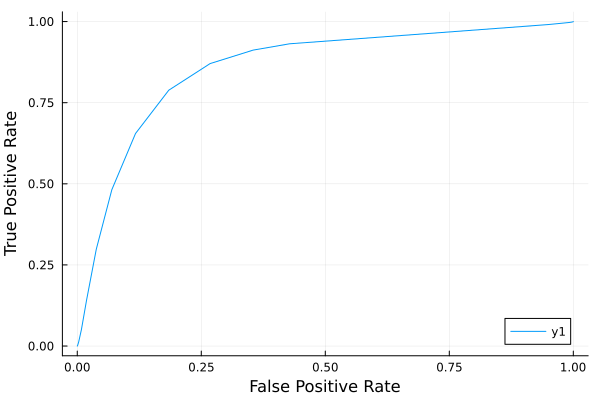

In [106]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

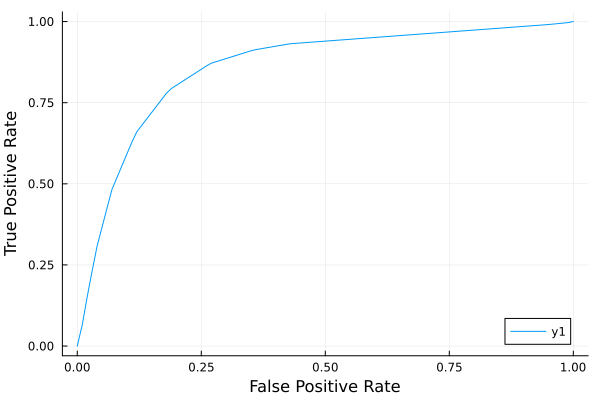

In [107]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [108]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8588220342351877, 1.0895323790620394e-8)

# Make a spiking version

In [224]:
# tspan_exec = (0.0, 30.0)
# spk_args_exec = SpikingArgs(solver=Tsit5(), leakage=-0.2)
tspan_exec = tspan
spk_args_exec = SpikingArgs(solver=Tsit5(), leakage=-0.2)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [288]:
n_t = floor(Int, 10000 / 128)

78

In [304]:
test_trains = test_train[1:n_t];

In [306]:
test_train_c = cat(test_trains..., dim=2)

Spike Train: (14, 9984) with 2949871 spikes.

In [307]:
n_test = size(test_train_c,2)

9984

In [308]:
#phase from the spike train 
ptrain = train_to_phase(test_train_c, spk_args=spk_args_exec);

In [309]:
size(ptrain)

(25, 14, 9984)

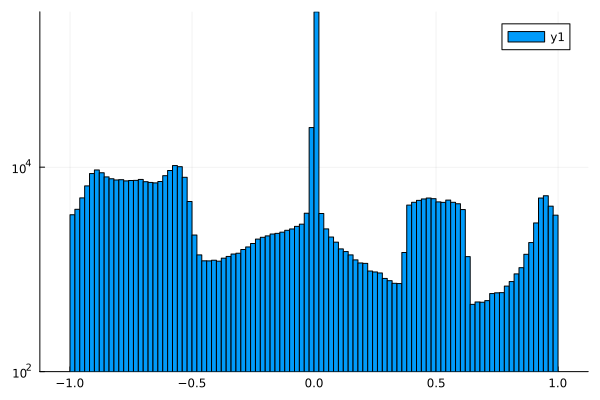

In [311]:
histogram(test_mp |> vec, yscale=:log10)

In [312]:
#correlation between the mean phase and spike train (basically perfect)
cycle_correlation(test_mp[:,1:n_test], ptrain)

25-element Vector{Float64}:
 1.0
 0.9999999999995249
 0.9999999999996729
 1.0
 1.0
 1.0
 1.0
 0.9999999999997202
 0.9999999999999513
 0.9999999999998702
 1.0
 1.0
 0.9999999999996666
 1.0
 0.9999999999995982
 0.9999999999998381
 0.9999999999997373
 1.0
 0.9999999999999958
 0.9999999999999898
 0.9999999999999908
 0.9999999999999877
 0.9999999999999861
 0.9999999999999848
 0.9999999999999807

In [323]:
test_calls = [SpikingCall(t, spk_args_exec, tspan_exec) for t in test_trains];

In [330]:
yspk = [@time ode_model(c, pst2, stt)[1] for c in test_calls]

 24.072554 seconds (2.15 M allocations: 49.182 GiB, 81.79% gc time)
 23.936421 seconds (2.15 M allocations: 49.183 GiB, 81.82% gc time)
 23.727983 seconds (2.16 M allocations: 49.182 GiB, 81.51% gc time)
 23.993239 seconds (2.15 M allocations: 49.182 GiB, 81.83% gc time)
 23.999606 seconds (2.15 M allocations: 49.183 GiB, 81.80% gc time)
 23.962293 seconds (2.15 M allocations: 49.183 GiB, 81.79% gc time)
 23.872700 seconds (2.15 M allocations: 49.182 GiB, 81.54% gc time)
 24.084223 seconds (2.15 M allocations: 49.182 GiB, 81.94% gc time)
 23.910791 seconds (2.15 M allocations: 49.181 GiB, 81.78% gc time)
 24.050078 seconds (2.15 M allocations: 49.183 GiB, 81.76% gc time)
 23.761038 seconds (2.15 M allocations: 49.182 GiB, 81.44% gc time)
 24.004202 seconds (2.15 M allocations: 49.182 GiB, 81.64% gc time)
 23.998356 seconds (2.15 M allocations: 49.182 GiB, 81.75% gc time)
 23.580242 seconds (2.15 M allocations: 49.182 GiB, 81.65% gc time)
 23.986566 seconds (2.15 M allocations: 49.182 G

78-element Vector{SpikingCall}:
 SpikingCall(Spike Train: (3, 128) with 9600 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0))
 SpikingCall(Spike Train: (3, 128) with 9600 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0))
 SpikingCall(Spike Train: (3, 128) with 9599 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0))
 SpikingCall(Spike Train: (3, 128) with 9600 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0))
 SpikingCall(Spike Train: (3, 128) with 9599 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0))
 SpikingCall(Spike Train: (3, 128) with 9600 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0))
 SpikingCall(Spike T

In [332]:
length(yspk)

78

In [334]:
yspk_full = cat([train_to_phase(st) for st in yspk]..., dims=3)

25×3×9984 Array{Float64, 3}:
[:, :, 1] =
 0.0162204   0.0139652   0.021324
 0.00741277  0.0195273   0.093051
 0.0113609   0.025717    0.248464
 0.0142882   0.0296314   0.43011
 0.0157528   0.0366267   0.551185
 0.0164281   0.054054    0.618769
 0.0167027   0.12071     0.658739
 0.0167694   0.727194    0.684511
 0.0167272   0.92046     0.702308
 0.0166288   0.951092    0.715222
 0.0165038   0.962522    0.724929
 0.0163691   0.968182    0.732412
 0.0162342   0.971398    0.738284
 0.0161047   0.973377    0.742953
 0.0159838   0.974658    0.7467
 0.0158728   0.975516    0.749727
 0.015772    0.976104    0.752182
 0.0149527   0.959345    0.663499
 0.0143362   0.911445    0.559258
 0.0138624   0.54859     0.460243
 0.0141967   0.0721873   0.400408
 0.0148673   0.0255836   0.367351
 0.0156202   0.0116321   0.348841
 0.0163446   0.00603695  0.338128
 0.00359702  0.00362538  0.00360775

[:, :, 2] =
 0.0162204    0.0139652   0.021324
 0.00741281   0.019529    0.0930516
 0.00776486   0.0233244   

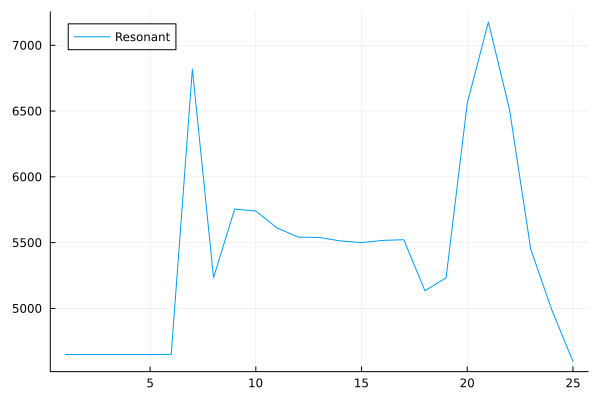

In [338]:
plot([accuracy_compare(aa, pt_test[1:n_test], 0.2) for aa in eachslice(yspk_full, dims=1)], label="Resonant")

In [341]:
function calc_auroc(yh)
    global n_test
    roc_spk = tpr_fpr(yh, pt_test[1:n_test])
    roc_fn_spk = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...);
    auc, _ = quadgk(roc_fn_spk, 0.0, 1.0)
    return auc
end

calc_auroc (generic function with 1 method)

In [346]:
map(calc_auroc, eachslice(yspk_full, dims=1)) |> maximum

0.8522733599913509

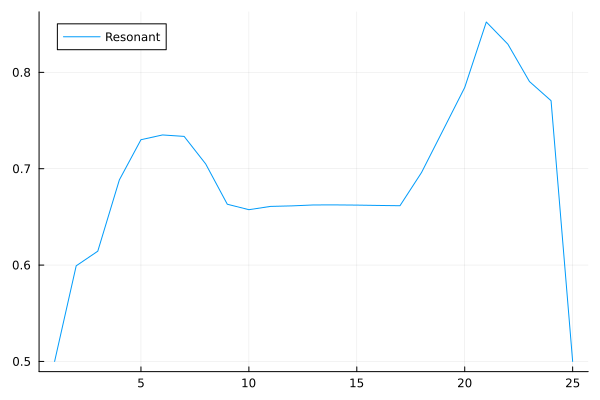

In [345]:
plot(map(calc_auroc, eachslice(yspk_full, dims=1)), label="Resonant")

In [236]:
ode_baby = Chain(
                PhasorDenseF32(n_in => 128),
                )

PhasorDenseF32((14, 128))  # 2_048 parameters

In [237]:
ps_baby = pst2.layer_1;

In [238]:
st_baby = st.layer_1;

In [239]:
y_baby_p, _ = ode_baby(test_mp[:,1:1000], ps_baby, st_baby);

In [240]:
y_baby, _ = ode_baby(test_call, ps_baby, st_baby)

(SpikingCall(Spike Train: (128, 1000) with 3199995 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0)), NamedTuple())

In [241]:
y_baby_direct, _ = ode_baby(test_call_phase, ps_baby, st_baby)

(SpikingCall(Spike Train: (128, 1000) with 3199990 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 25.0)), NamedTuple())

In [242]:
y_baby_spk = train_to_phase(y_baby);

In [243]:
y_baby_direct_p = train_to_phase(y_baby_direct);

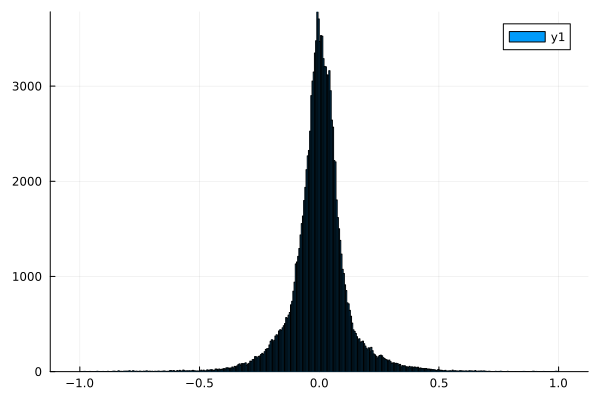

In [244]:
histogram(vec(y_baby_p))

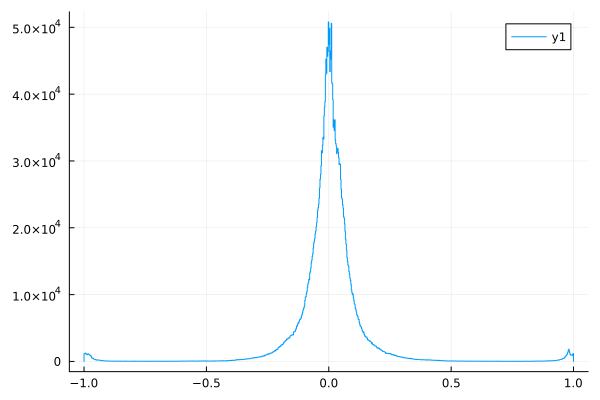

In [245]:
histogram(vec(y_baby_spk))

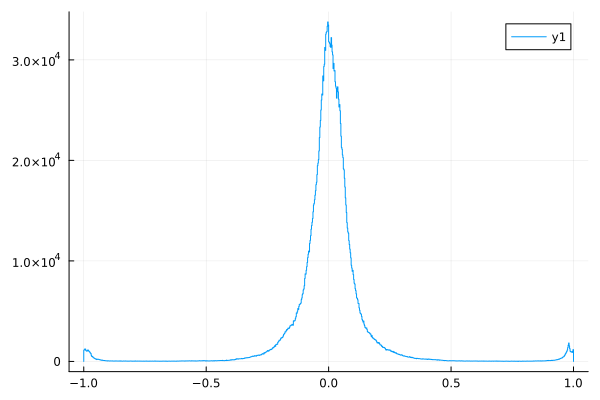

In [246]:
histogram(vec(y_baby_spk[5:end,:,:]))

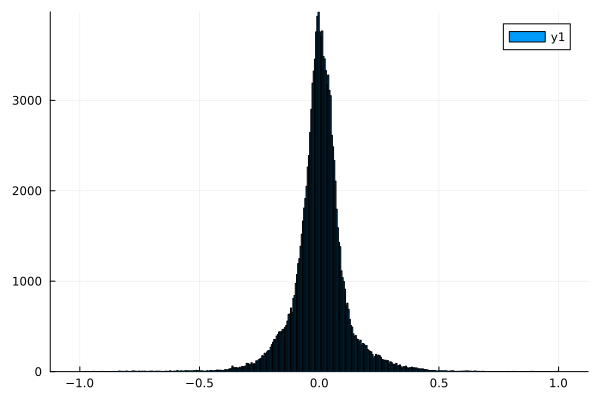

In [247]:
histogram(vec(y_baby_spk[10,:,:]))

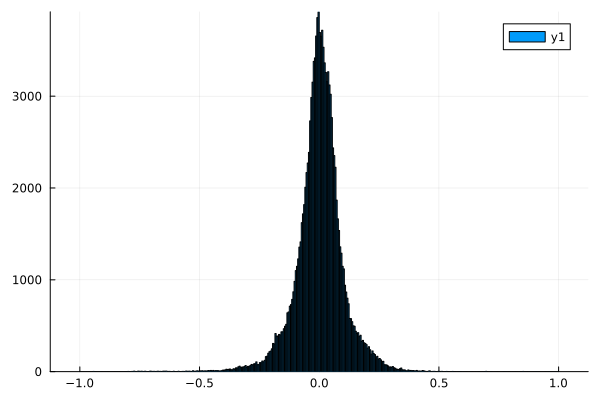

In [248]:
histogram(vec(y_baby_spk[end-5,:,:]))

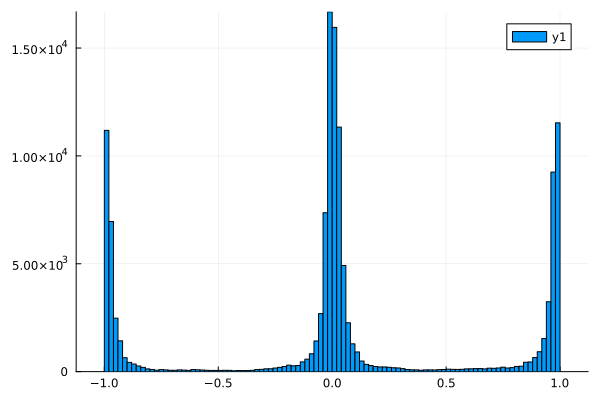

In [249]:
histogram(vec(y_baby_spk[end,:,:]))

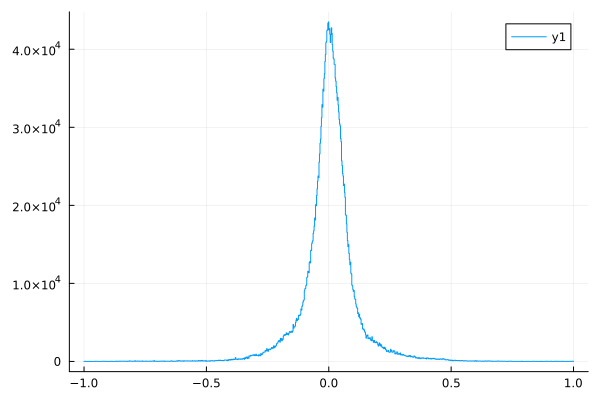

In [250]:
histogram(vec(y_baby_direct_p))

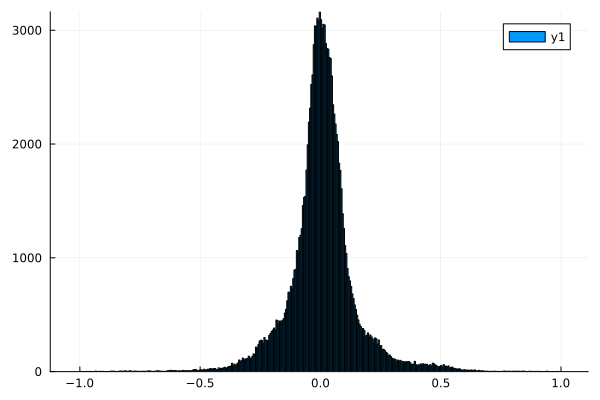

In [251]:
histogram(vec(y_baby_direct_p[1,:,:]))

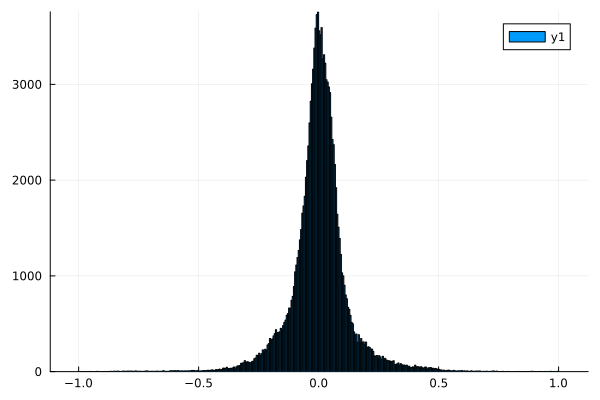

In [252]:
histogram(vec(y_baby_direct_p[5,:,:]))

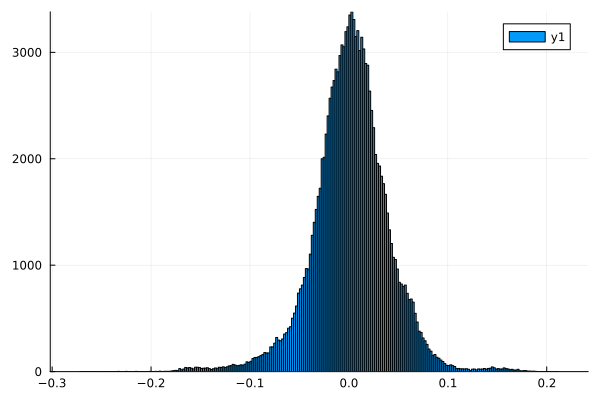

In [253]:
histogram(vec(y_baby_direct_p[end-1,:,:]))

In [254]:
size(y_baby_p)

(128, 1000)

In [255]:
size(y_baby_spk)

(25, 128, 1000)

In [256]:
spk_args_exec.solver

Tsit5(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)

In [257]:
spk_args_exec.solver_args

Dict{Symbol, Any} with 4 entries:
  :adaptive   => false
  :sensealg   => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(Zygote…
  :dt         => 0.01
  :save_start => true

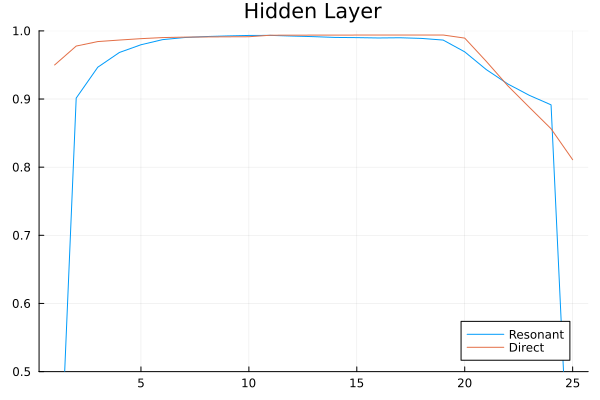

In [258]:
plot(cycle_correlation(y_baby_p, y_baby_spk), label="Resonant")
plot!(cycle_correlation(y_baby_p, y_baby_direct_p), label="Direct")
ylims!(0.50, 1.0)
title!("Hidden Layer")

In [259]:
yspk_p = train_to_phase(yspk);

In [260]:
yspk_p2 = train_to_phase(yspk2);

In [261]:
size(yth[:,1:1000])

(3, 1000)

In [262]:
size(yspk_p)

(25, 3, 1000)

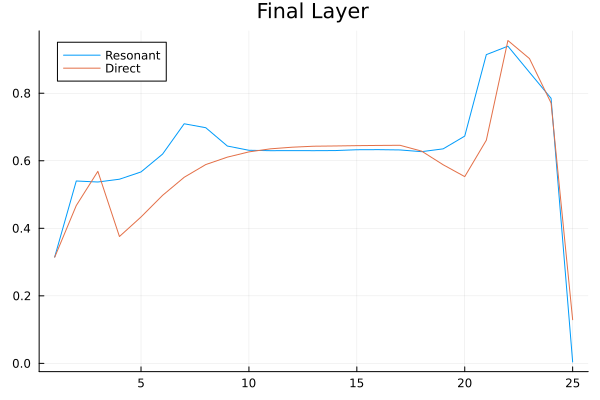

In [263]:
plot(cycle_correlation(yth[:,1:1000], yspk_p), label="Resonant")
plot!(cycle_correlation(yth[:,1:1000], yspk_p2), label="Direct")
title!("Final Layer")

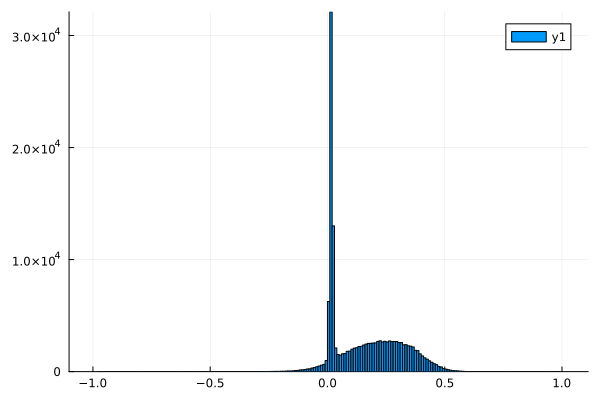

In [264]:
histogram(vec(yth))

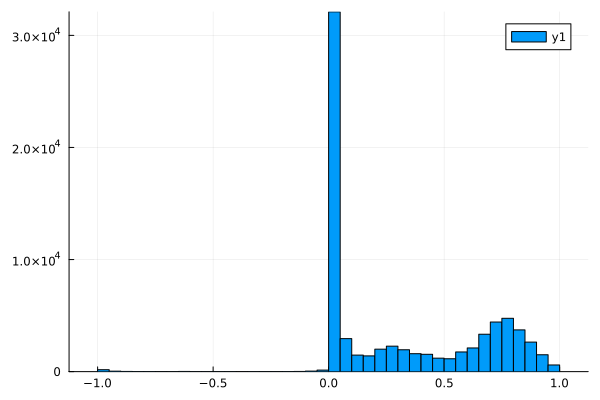

In [265]:
histogram(vec(yspk_p))

In [266]:
yspk_p2 = train_to_phase(yspk2);

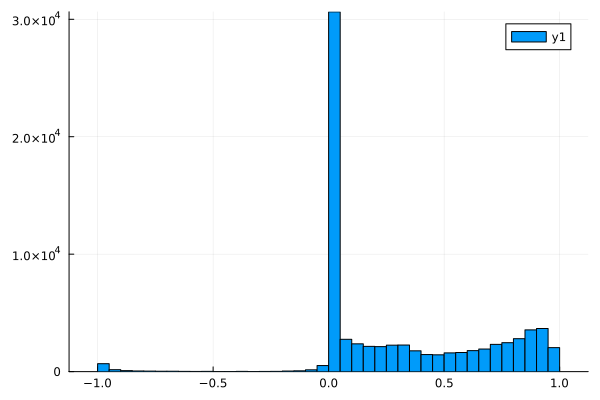

In [267]:
histogram(vec(yspk_p2))

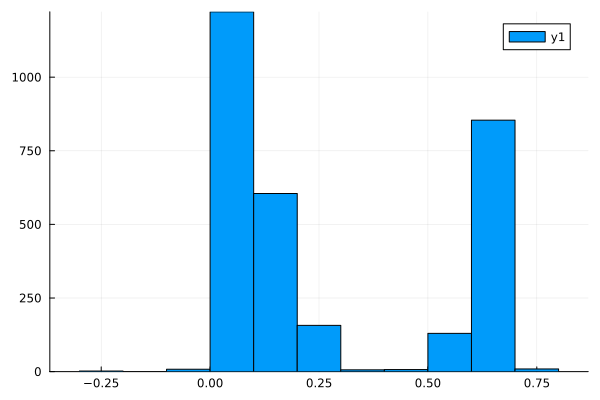

In [268]:
histogram(vec(yspk_p[6,:,:]))

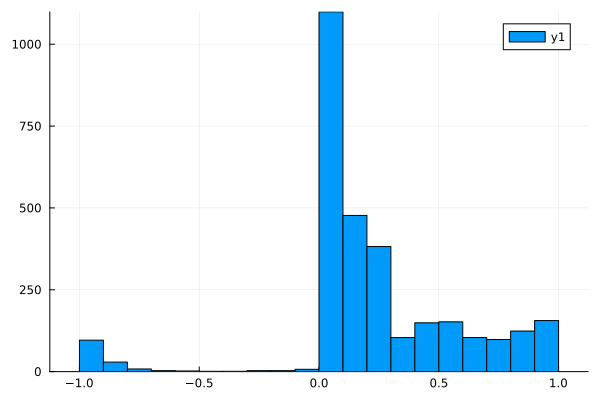

In [269]:
histogram(vec(yspk_p2[5,:,:]))

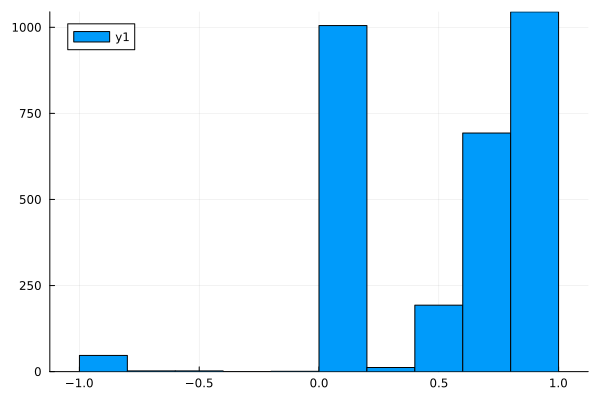

In [270]:
histogram(vec(yspk_p2[15,:,:]))

In [271]:
size(yspk_p)

(25, 3, 1000)

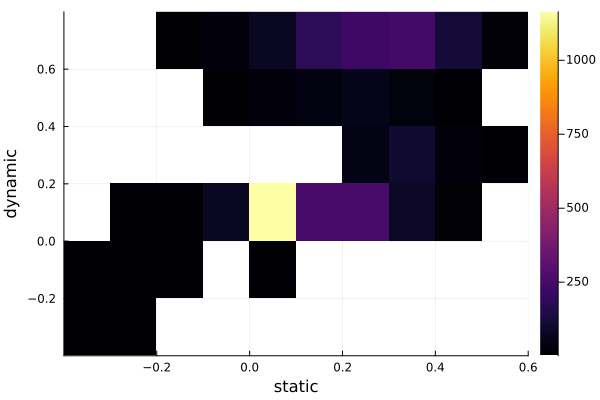

In [272]:
histogram2d(yth[:,1:1000] |> vec, yspk_p[6,:,:] |> vec)
xlabel!("static")
ylabel!("dynamic")

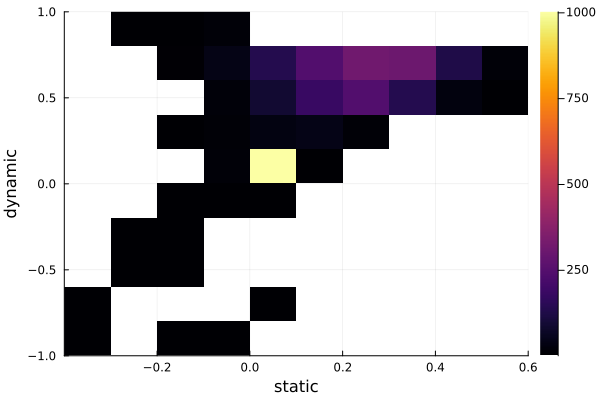

In [273]:
histogram2d(yth[:,1:1000] |> vec, yspk_p[8,:,:] |> vec)
xlabel!("static")
ylabel!("dynamic")

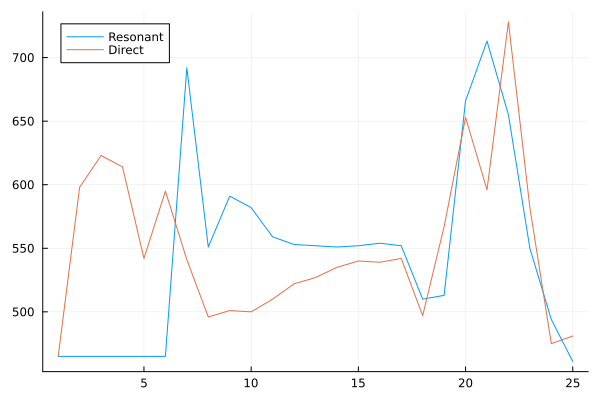

In [274]:
plot([accuracy_compare(aa, pt_test[1:1000], 0.2) for aa in eachslice(yspk_p, dims=1)], label="Resonant")
plot!([accuracy_compare(aa, pt_test[1:1000], 0.2) for aa in eachslice(yspk_p2, dims=1)], label="Direct")

In [275]:
function calc_auroc(yh)
    roc_spk = tpr_fpr(yh, pt_test[1:1000])
    roc_fn_spk = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...);
    auc, _ = quadgk(roc_fn_spk, 0.0, 1.0)
    return auc
end

calc_auroc (generic function with 1 method)

In [276]:
map(calc_auroc, eachslice(yspk_p, dims=1))

25-element Vector{Float64}:
 0.5
 0.5987499997353385
 0.614506340653906
 0.6907144850338836
 0.7314745253173599
 0.7336632416738608
 0.7295017543206757
 0.6978618616638684
 0.6555979063357157
 0.651392202865911
 0.6566577980460689
 0.6596907509397445
 0.6588390853839704
 0.6580246661230627
 0.6603474993124144
 0.660059748292929
 0.6598394176989711
 0.6923243654912409
 0.736726337888481
 0.781805994876337
 0.849761220928208
 0.829040250576455
 0.7905687489340092
 0.7716422459904216
 0.5

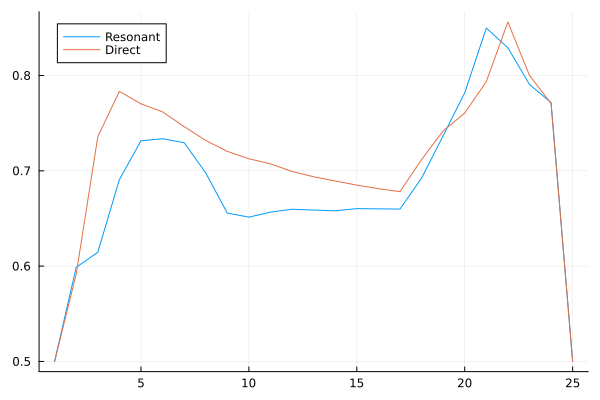

In [277]:
plot(map(calc_auroc, eachslice(yspk_p, dims=1)), label="Resonant")
plot!(map(calc_auroc, eachslice(yspk_p2, dims=1)), label="Direct")